# Analysis of the  ZooLake dataset versions
This notebook contains an explorative data analysis to compare the class distirbutions of the diffrent dataset versions of ZooLake. It's based on the original file `analyse_dataset.py` from the repo [plankifier](https://github.com/mbaityje/plankifier/tree/master) by M. Baitsy. 

## 1 Introduction
The ZooLake dataset is an open data project from Eawag that aims to automate the classification of 35 different lake plankton species using deep learning and other machine learning algorithms. The objective of the image classification is to enable the monitoring of the different plankton populations over time, as plankton are effective indicators of environmental change and ecosystem health in freshwater habitats.

TThe collection of images of plankton is an ongoing process, with the objective of improving the classification through the addition of more images. he most recent images that have not yet been manually labelled by a taxonomist can be accessed via the webpage [Aquascope](https://aquascope.ch/) located under the heading 'Latest Greifensee.' The new unlabelled images are being labelled manually by taxonomists over time. Once a sufficient number of images have been labelled, a new labelled collection is published. These collections represent the different ZooLake versions. 

The data set also include files, to recreate the same test/validation/train to make the model training and testing of the models comparable and reproducible.

### 1.1 Public data set versions

As of the present date, 20 September 2024, they are a two version of the ZooLake data set aviable for the public on the eawag open research page eric. This inculde following Versions:

- [ZooLake](https://opendata.eawag.ch/dataset/deep-learning-classification-of-zooplankton-from-lakes),  is the initial version of the dataset referenced by the paper 'Deep Learning Classification of Lake Zooplankton' with a tota of 17900 labelled images.

- [Zoolake2.0](https://data.eawag.ch/dataset/data-for-producing-plankton-classifiers-that-are-robust-to-dataset-shift), second version of the data set, which include more labelled data and the introduction of the *out-of-dataset (OOD)*. The OOD was utilised by C. Cheng et al. (2024) in their research into producing plankton classifiers that are robust to dataset shift. It also mentioned there,  that the ZooLake2.0 images come with a 2-year gap of the fist ZooLake Version and a total of 24'000 images


-  [Zoolake3.0](https://opendata.eawag.ch/) incomming...

### 1.2 Objectives of the explorativ analysis

This explorativ data anlysis notebook aim to research following points:

- Are they any  duplicates images?
- How are the distirbutions of the diffrent planton classes compared over the differnt data sets
- Are the old version of the test/train/validation sets subsets of the new versions splits, as mentioned by Chen et la.
- Are they any data leakage betweens of the old and new versions test/train splits


## 2 Creation of the dataframe for the analysis

In order to achieve the above mentioned objectives of the analysis, a data frame is constructed with the requisite information extracted from the data structur as datasetversion, image name and foldername. A significant challenge arises from the fact that a substantial proportion of the data comprises the content of the image. Consequently, the creation of a data set based solely on the image name may prove to be of limited value. In order to more effectively analyse the content of the images for duplicates, diffrent hashes algorithm are created to check the individual images.


## 2.1 Local data strcutur

The local data folder strcuture refers to the cookie-cutter layout. The structure is as illustrated in the structure tree below. The folder designated for external data has been removed, as there is no external data utilized in this project. 


```md
    data
    ├── external       <- removed (no data from third party sources) 
    ├── interim        <- Intermediate data with all images from the diffrent dataset versions.
    ├── processed      <- Data sets for modeling, splitted by train/test/validation/OOD.
    └── raw            <- original data, correspond the files downloaded from eric download.
```
During the setup, the folder *processed*  is always configured with a split based on the latest available version of Zoolake.  However, this can be modified prior to modelling.

### 2.1 Features based on the structur of the data

The file names of the individual images and folders contain detailed information regarding the specific class and the time at which the image was captured. In the case of the Zoolake, the file name of the image in question is structured as follows, where the "nk" stands for not known information and "img" for image:

\begin{array}{cccccccccccccccc}
\text{SPC-EAWAG-0P5X} & \text{-} & \text{1559498410} & \text{-} & \text{191177} & \text{-} & \text{6403834470} & \text{-} & \text{952} & \text{-} & \text{000009} & \text{-} & \text{061} & \text{-} & \text{1220} & \text{-} & \text{2378} & \text{-} & \text{52} & \text{-} &\text{40} & \text{.jpeg} \\
\textit{Camera information} &&  \textit{Unix timestamp} & & \textit{nk} & & \textit{nk} & & \textit{nk} & & \textit{nk} & & \textit{nk} & & \textit{nk} & & \textit{nk} & & \textit{img width} & & \textit{img height}
\end{array}


The data structure is organised in the manner demonstrated below. The data basis of the first version is displayed on the left, with that of the second version being shown on the right. The pickle files contain the image data path and if the image is inside  the test, train orvalidation split. In the first Version of the dataset, they provided this information also as .txt file. 

```md

            ZooLake1                                  ZooLake2.0
        zooplankton_0p5x/                           zooplankton2/  
        ├── aphanizomenon/                          ├── aphanizomenon/
        │   ├── training_data/                      │   ├── image1.jpg    
        │   │   ├── image1.jpeg                     │   └── ...│        
        │   │   └── ...                             ├── class2/
        │   └── features.tsv                        │   ├── image1.jpg         
        ├── class2/                                 │   ├── image2.jpg
        │   ├── training_data                       │   └── ...   
        │   │   ├── image1.jpeg                     ├── ...                 
        │   │   └── ...                             └── Files_used_for_training_testing.pickle                                             
        │   └── features.tsv                                           
        ├──  ...
        └──  zoolake_train_test_val_separated/ 
            ├── classes_ERIC.npy
            ├── Data.pickle
            ├── test_filenames.txt
            ├── train_filenames.txt
            └── val_filenames.txt        
            
``` 

### 2.2 Hashing of images for the search of duplicates

The process of hashing images with the objective of identifying identical or near-identical duplicates represents a own field of research. This field of research is not only of great interest for data quality reason, it finds big interesst with regard to legal issues, such as findig similar images or videos that violate copyright or search of illegal evidence.

#### 2.2.1 Comparasion of hash algorithms

Clasic cryptographic hash functions compress an input text AS binary code into an output HASH with a fixed length, which can be used to straightforwardly test whether the two loaded images are identical down to each pixel value. Consequently, cryptographic algorithms such as SHA-256 for image hashing is limited by the fact that they are sensitive to even minor changes like rotation, cropping the image or the changing the colours of only one pixel results in the generation of an entirely new hash value.

Hash algorithms speficied to hah image with greater specificity can be employed to circumventing the above-mentioned issues. A commonly utilised approach is the perceptual hash function also knwon as phash. A parshing hash algorithm reduces the image down to a set size and anlyse diffrent features of the image like frequenzcy components. However, the reduction can results in the case of plankton classifier to  false positive duplicate findings, since the images of the plantons in each class can be realy simular. Researches like [*Analysis of Perceptual Hashing Algorithms in Image Manipulation Detection*](https://doi.org/10.1016/j.procs.2021.05.021) compare the phash other approaches that focus on diffrent components of the image.


| Hash algorithm | Positive aspects                                                                 | Negative aspects                                                                 |
|----------------|----------------------------------------------------------------------------------|----------------------------------------------------------------------------------|
| SHA-256        | High specificity, detects even minor changes in images                           | Sensitive to minor changes, different hash for rotated/cropped images             |
| Perceptual hash (phash) | Robust to minor changes like rotation or croppping of images            | Since similar images of classes can have the same hashcode, it could create false postiv duplicate findings |      |


### 2.3 Import of the data

In order to import the individual images, it was deemed appropriate to search for each image within the data versions folders and save the determined path and filename inside a dictionary. This approach was selected as it allowed for the most accurate and precise identification of the image files. The existing file paths from the text or pickle files were deliberately excluded from the process of creating the data frame. This was done to guarantee that all files inside the data version are included.

In [3]:
from datetime import datetime as dt
import os
from PIL import Image
import hashlib
from tqdm import tqdm

import imagehash
import numpy as np
import pandas as pd


def create_dataset(dic_dataset, phash = False):
    # empty list to store the defined data
    lst = []

    # loop through each dataset versions
    for version,  class_folder in dic_dataset.items():

        # loop through each class folder and keep track of the progress
        for  planton_class in tqdm(os.listdir(class_folder), total=len(os.listdir(class_folder)), desc=f'Hashing images from dataset version {version}'):

            # loop through each file/image in the class folder
            for root, _, files in os.walk(os.path.join(class_folder, planton_class)):
                for file in files:

                    # check if the file is an image
                    if file.endswith('.jpeg'):

                        # open the image to hash it
                        with open(os.path.join(root, file), 'rb') as f:
                            image = f.read()
                        
                        # hash the image
                        hash_obj = hashlib.sha256()
                        hash_obj.update(image)
                        image_hash = hash_obj.hexdigest()

                        if phash:
                        # calculate the perceptual hash
                            phash = str(imagehash.phash(Image.open(os.path.join(root, file))))
                            lst.append({'image': file,
                                        'hash_256': image_hash, 
                                        'phash' : phash, 
                                        'class': planton_class,
                                        'data_set_version': int(version),
                                        'date':  dt.fromtimestamp(int(file.split('/')[-1][15:25]))})    

                        # add more features based on filename and parent dir  
                        lst.append({'image': file,
                                              'hash_256': image_hash, 
                                              'class': planton_class,
                                              'data_set_version': int(version),
                                              'date':  dt.fromtimestamp(int(file.split('/')[-1][15:25]))})

    return lst


To load the folder we define the path to folder containing the diffrent dataset versions and run the `create_dataset` function to get the diffrent image datasets

In [2]:

zoolake_versions_dic = {'1': os.path.join('..','data','raw', 'data', 'zooplankton_0p5x'),
                        '2': os.path.join('..','data','raw', 'ZooLake2', 'ZooLake2.0')}

image_hashes = create_dataset(zoolake_versions_dic)
image_hashes_df = pd.DataFrame(image_hashes)
image_hashes_df.head()


# modular loop inside the src/create_dataset.py file

Hashing images from dataset version 2: 100%|██████████| 35/35 [00:01<00:00, 20.99it/s]


,image,hash_256,class,data_set_version,date
0,SPC-EAWAG-0P5X-1570543372901157-3725350526242-...,a957e3fb302aa924ea62f25b436893151640dc05f761c4...,aphanizomenon,1,2019-10-08 16:02:52
1,SPC-EAWAG-0P5X-1570543374882008-3725352526408-...,ae432b9dd431466a2cb61098506a1b472e363b8d4851f2...,aphanizomenon,1,2019-10-08 16:02:54
2,SPC-EAWAG-0P5X-1589472012505862-10217420880920...,70e3a671313aff3b006af2cad3626eaa4baa28361af214...,aphanizomenon,1,2020-05-14 18:00:12
3,SPC-EAWAG-0P5X-1589472120505648-10217528889899...,33980bbce3b9ac05c91d6154f6e2bdae0deddecd683a42...,aphanizomenon,1,2020-05-14 18:02:00
4,SPC-EAWAG-0P5X-1589472215513831-10217623897796...,0bb1bd78f1a9e9fe8828a5cca1881cfd110d865ed8faba...,aphanizomenon,1,2020-05-14 18:03:35


,image,hash_256,class,data_set_version,date
0,SPC-EAWAG-0P5X-1570543372901157-3725350526242-...,a957e3fb302aa924ea62f25b436893151640dc05f761c4...,aphanizomenon,1,2019-10-08 16:02:52
1,SPC-EAWAG-0P5X-1570543374882008-3725352526408-...,ae432b9dd431466a2cb61098506a1b472e363b8d4851f2...,aphanizomenon,1,2019-10-08 16:02:54
2,SPC-EAWAG-0P5X-1589472012505862-10217420880920...,70e3a671313aff3b006af2cad3626eaa4baa28361af214...,aphanizomenon,1,2020-05-14 18:00:12
3,SPC-EAWAG-0P5X-1589472120505648-10217528889899...,33980bbce3b9ac05c91d6154f6e2bdae0deddecd683a42...,aphanizomenon,1,2020-05-14 18:02:00
4,SPC-EAWAG-0P5X-1589472215513831-10217623897796...,0bb1bd78f1a9e9fe8828a5cca1881cfd110d865ed8faba...,aphanizomenon,1,2020-05-14 18:03:35


### 3 Testing of the diffrent images 



In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [46]:
image_hashes_df = pd.DataFrame(image_hashes)
image_hashes_df.head()

,image,hash_256,class,data_set_version,date
0,SPC-EAWAG-0P5X-1570543372901157-3725350526242-...,a957e3fb302aa924ea62f25b436893151640dc05f761c4...,aphanizomenon,1,2019-10-08 16:02:52
1,SPC-EAWAG-0P5X-1570543374882008-3725352526408-...,ae432b9dd431466a2cb61098506a1b472e363b8d4851f2...,aphanizomenon,1,2019-10-08 16:02:54
2,SPC-EAWAG-0P5X-1589472012505862-10217420880920...,70e3a671313aff3b006af2cad3626eaa4baa28361af214...,aphanizomenon,1,2020-05-14 18:00:12
3,SPC-EAWAG-0P5X-1589472120505648-10217528889899...,33980bbce3b9ac05c91d6154f6e2bdae0deddecd683a42...,aphanizomenon,1,2020-05-14 18:02:00
4,SPC-EAWAG-0P5X-1589472215513831-10217623897796...,0bb1bd78f1a9e9fe8828a5cca1881cfd110d865ed8faba...,aphanizomenon,1,2020-05-14 18:03:35


In [78]:
def create_duplicate_df(df):
    '''Create a bar plot showing the number of duplicates per hash algorithm with each sub-column as a dataset version.'''
    
    # Get all columns with 'hash' in the name
    hash_columns = [col for col in df.columns if 'hash' in col]

    duplicate_data = []
    
    # Loop through each hash column and calculate the number of duplicates per dataset version
    for hash_col in hash_columns:
        duplicates = df[df.duplicated(subset=[hash_col, 'data_set_version'], keep=False)].copy()

        # Group by hash_col and DataSetVersion
        group_counts = (
            duplicates.groupby([hash_col, 'data_set_version'])
            .agg(
                count=('class', 'size'),  # Count the number of duplicates
                diffrent_class=('class', lambda x: x.nunique() != 1)  # True if duplicates are in different classes
            )
            .reset_index()
        )
        
        group_counts['count'] = group_counts['count'].astype(int)
               
        group_counts['hash'] = hash_col  # Add hash column for identification
        
        duplicate_data.append(group_counts)
    
    # Combine the results from each hash algorithm into a single DataFrame
    duplicate_counts_df = pd.concat(duplicate_data)

    return duplicate_counts_df

create_duplicate_df(image_hashes_df)

,hash_256,data_set_version,count,diffrent_class,hash
0,198441d850f81983c05a42682147c5b1447eceec379d90...,1,2,True,hash_256
1,5a500c455fc66fb19d5de5169170b4efb455669d2d5300...,1,2,True,hash_256
2,5ef26eef2b4e59514257758acf7c152dd4f2ae290d00a5...,1,2,True,hash_256


In [79]:
def plot_barplot_duplicates(df):
    '''Create a bar plot showing the number of duplicates per hash algorithm with each sub-column as a dataset version.'''
    
    # Combine the results from each hash algorithm into a single DataFrame
    duplicate_counts_df = create_duplicate_df(df)

    # Get all the diffrent hash algorithms
    hash_columns = duplicate_counts_df['hash'].unique()

    # Create subplots for each hash algorithm
    fig, axes = plt.subplots(1, len(hash_columns), figsize=(9 * len(hash_columns), 5))

    # Ensure axes is always a list (even if there is only one column)
    if len(hash_columns) == 1:
        axes = [axes]

    # Loop through each hash column and plot the data
    for i, hash_col in enumerate(hash_columns):
        sns.barplot( data=duplicate_counts_df[duplicate_counts_df['hash'] == hash_col],
            x='data_set_version', y='count', 
            errorbar=None, ax=axes[i], estimator=sum
        )
        
        total_duplicates = duplicate_counts_df[duplicate_counts_df['hash'] == hash_col]['count'].sum()
        axes[i].set_title(f'{hash_col} (Total: {total_duplicates})')
        axes[i].set_xlabel('ZooLake Version')
        axes[i].set_ylabel('Number of Duplicates' if i == 0 else '')
        
        # Add bar labels to each bar in the plot also 0 values
        for container in axes[i].containers:
            axes[i].bar_label(container)
        
        # Set legend to be consistent across subplots    
    plt.suptitle('Number of Duplicates per Hash Algorithm', size=14)
    plt.tight_layout()


    return plt


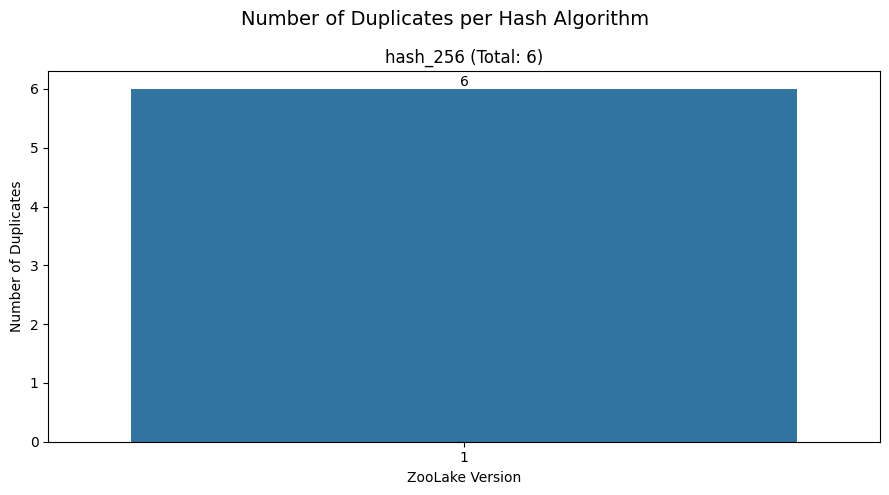

In [80]:
plot_barplot_duplicates(image_hashes_df).show()

In [109]:
def barplot_duplicates_per_class(df):
    '''create a bar plot with numbers of duplicate groups per hash alorithm with each subcolumn a datasetversion
     and a hue if the duplicates are in the same class or not'''
    
    # Combine the results from each hash algorithm into a single DataFrame
    duplicate_counts_df = create_duplicate_df(df)

    # Get all the diffrent hash algorithms
    hash_columns = duplicate_counts_df['hash'].unique()

    fig, axes = plt.subplots(1, len(hash_columns),  sharey=True)

    # Ensure axes is always a list (even if there is only one column)
    if len(hash_columns) == 1:
        axes = [axes]


    for i, hash_col in enumerate(hash_columns):

        ax = axes[i]
        
        subset = duplicate_counts_df[duplicate_counts_df['hash'] == hash_col]
        
        total_duplicates = subset['count'].sum()
        
        sns.barplot(data=subset, x ='data_set_version', y = 'count', hue = 'diffrent_class', dodge = True, errorbar = None, ax = ax, estimator=sum)
        
        ax.set_title(f'{hash_col} (Total: {total_duplicates})')
        ax.set_xlabel('ZooLake Version')
        ax.set_ylabel('Number of Duplicates')

        if len(hash_columns) > 1:
            ax.legend(title='diffrent class', labels=[ 'True', 'False'])

        #
        ax.set_prop_cycle(color=['#1f77b4', '#ff7f0e'])
        [ax.bar_label(i,) for i in ax.containers]

    plt.suptitle('Number of duplicate groups per hash algorithm with class distinction', size=16)
    plt.xlabel('ZooLake Version')
    plt.tight_layout()  
 
    return plt


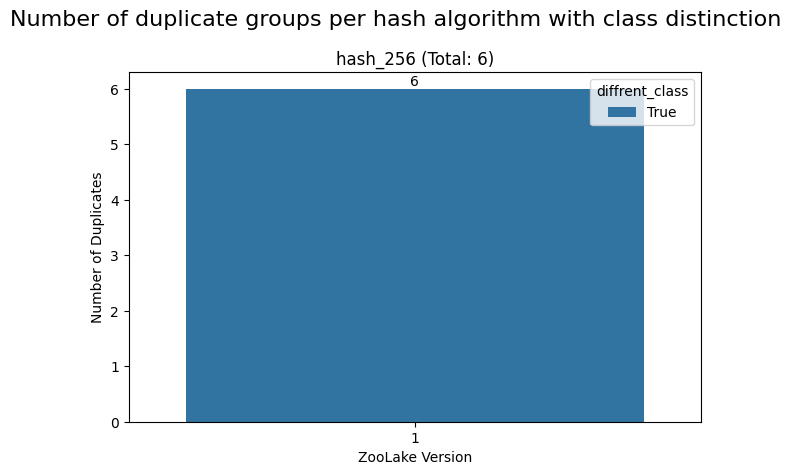

In [110]:

barplot_duplicates_per_class(image_hashes_df).show()


In [156]:
def plot_images_with_same_hash(image_hashes_df, hash_algorithm = 'hash256', dataset_version='ZooLake2', notsameclass_duplicates=True):
    ''' Plots images with the same hash value and dataset version

    Args:
        image_hashes_df: pd.DataFrame, dataframe containing image hashes and file names as column

    Returns:
        None
    '''
    if hash_algorithm == 'hash256':
        # get images with the same hash value
        duplicate_hashes = image_hashes_df[image_hashes_df.duplicated(subset=['hash_256', 'data_set_version'], keep=False)]
        # rename hash column
        duplicate_hashes = duplicate_hashes.rename(columns={'hash_256': 'hash'})

    elif hash_algorithm== 'phash':
        duplicate_hashes = image_hashes_df[image_hashes_df.duplicated(subset=['phash', 'data_set_version'], keep=False)]
        # include only 20 samples
        duplicate_hashes = duplicate_hashes.rename(columns={'phash': 'hash'})

    if dataset_version == 1:
        duplicate_hashes = duplicate_hashes[duplicate_hashes['data_set_version'] == 1]
    elif dataset_version == 2:
        duplicate_hashes = duplicate_hashes[duplicate_hashes['data_set_version'] == 2]
    else :
        duplicate_hashes = duplicate_hashes

    # filter the duplicates to include only subset of hash values with diffrent classes
    if notsameclass_duplicates:
        duplicate_hashes = duplicate_hashes.groupby('hash').filter(lambda x: x['class'].nunique() > 1)
        # filter so that only one image per class is included
        duplicate_hashes = duplicate_hashes.groupby(['hash', 'class']).head(1)

    
    # get unique hash values
    unique_hashes = duplicate_hashes['hash'].unique()

    if len(unique_hashes) == 0:
        # empty plot with message
        text_plot = f'No images with the same hash value inside Zoolake{dataset_version} using the {hash_algorithm} algorithm '
        plt.text(0.5, 0.5, s = text_plot, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.axis('off')
        plt.tight_layout()
        return plt

    # limit the number of images to be plotted to the 5 hash values with the most images
    unique_hashes = duplicate_hashes.groupby('hash').size().head().index

    # get the maximum number of images with the same hash value
    max_images = duplicate_hashes[duplicate_hashes['hash'].isin(unique_hashes)].groupby('hash').size().max()


    fig, axs = plt.subplots( max_images, len(unique_hashes),figsize=(8, 6))
    for j, hash_value in enumerate(unique_hashes):

        # get images with the same hash value
        images = duplicate_hashes[duplicate_hashes['hash'] == hash_value]
        images = images.sort_values(by='image')

        for i, row in enumerate(images.iterrows()):
            # read jpeg image
            if row[1]['data_set_version'] == 1:
 
                img = mpimg.imread(os.path.join(zoolake_versions_dic[str(row[1]['data_set_version'])], row[1]['class'], 'training_data', row[1]['image']))
            else:
                img = mpimg.imread(os.path.join(zoolake_versions_dic[str(row[1]['data_set_version'])], row[1]['class'], row[1]['image']))
            
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            axs[i, j].set_title(f'{hash_value[:6]} \n {row[1]["class"]}')

        # remove empty subplots
        for k in range(i+1, max_images):
            fig.delaxes(axs[k, j])

    fig.suptitle(f'Images from ZooLake{dataset_version} with same hash using the {hash_algorithm} algorithm')
    plt.tight_layout()

    return plt
   

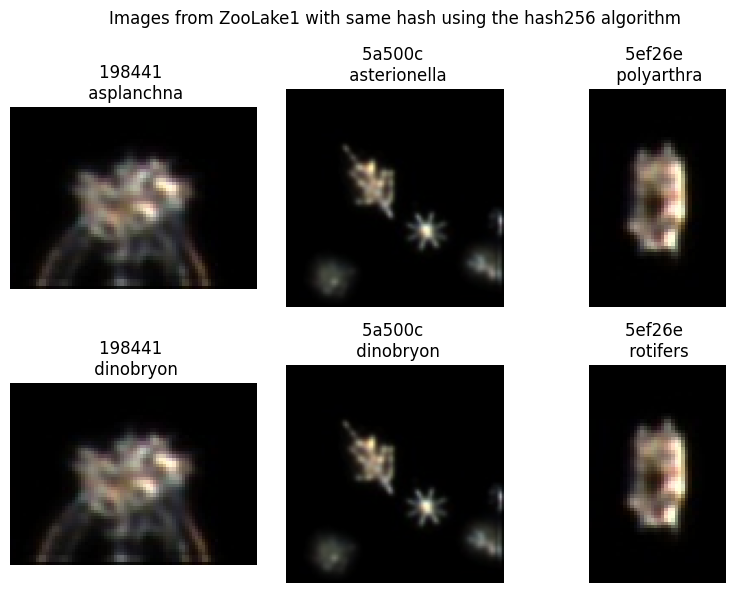

In [157]:
 
plot_images_with_same_hash(image_hashes_df, hash_algorithm='hash256', dataset_version=1).show()



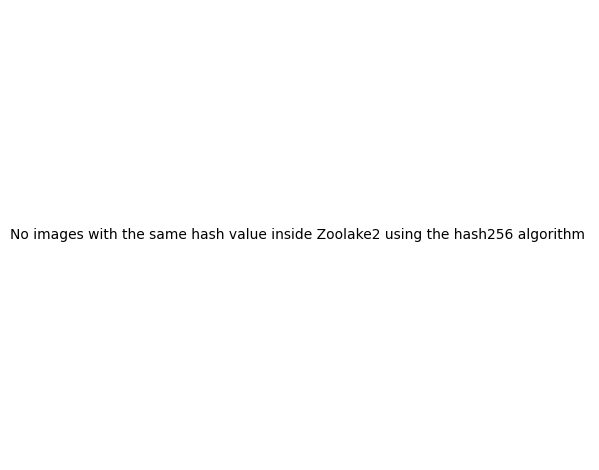

In [158]:
plot_images_with_same_hash(image_hashes_df, hash_algorithm='hash256', dataset_version=2).show()

## Test Train split

In [10]:

# check if the hash values are the same for the same image
df_grouped = image_hashes_df.groupby('image').agg(
    was_hash_same=('hash_256', lambda x: x.nunique() == 1)
).reset_index()

count_imagees_v2 = len(image_hashes_df)
print(f'From {count_imagees_v2} images, {df_grouped["was_hash_same"].sum()} have the same hash value over the diffrent versions')

count_v1    = len(image_hashes_df[image_hashes_df['DataSetVersion'] == 1])
count_v2    = len(image_hashes_df[image_hashes_df['DataSetVersion'] == 2])

print(f'difffrence in hash values between the two versions: { count_v2- count_v1 }')

From 47442 images, 29500 have the same hash value over the diffrent versions
difffrence in hash values between the two versions: 0


In [20]:
# melt the dataframe to have the hash values in one column and the dataset version in another (dataversion 1 as binary cpolumn (1 is there, 0 not there), dataversion two1 is there, 0 not there)

def melt_hash_df(df):

    df['isin_dataversion_1'] = df['DataSetVersion'] == '1'
    df['isin_dataversion_2'] = df['DataSetVersion'] == '2'
    df_pivot = df.pivot_table(index='image', aggfunc='first').reset_index()

    return df_pivot


melted_df = melt_hash_df(image_hashes_df)

melted_df.head()

,image,Class,DataSetVersion,date,hash_256,isin_dataversion_1,isin_dataversion_2,phash
0,SPC-EAWAG-0P5X-1526947357532857-1089211110251-...,ceratium,1,2018-05-22 02:02:37,227e63a2e1edea75850bb0c46cd5aa31407e4572349765...,True,False,cecc613319ccc6d3
1,SPC-EAWAG-0P5X-1526947464531326-1089318119146-...,daphnia,1,2018-05-22 02:04:24,7bee32f85c871d016aa0cbcb9fc70c465103a34552c769...,True,False,97976321988c6773
2,SPC-EAWAG-0P5X-1526947603555156-1089457130702-...,daphnia,1,2018-05-22 02:06:43,0078899b14078710441335d9f3b01fd5bb1222207349f4...,True,False,8c6933ce9c3927cc
3,SPC-EAWAG-0P5X-1526947642556033-1089496133944-...,eudiaptomus,1,2018-05-22 02:07:22,dd8e818b8549018d7b96e3e6df77c44630f16374ac5d73...,True,False,99cc6633398c9bc6
4,SPC-EAWAG-0P5X-1526947868572286-1089722152732-...,daphnia,1,2018-05-22 02:11:08,1d84a5a43af59338f316b8f38be6046446bf685264e36d...,True,False,cf64309bcf3418c7


In [12]:
# Get the hashes for DataSetVersion 1 and 2
hashes_version_1 = set(image_hashes_df[image_hashes_df['DataSetVersion'] == '1']['image'])
hashes_version_2 = set(image_hashes_df[image_hashes_df['DataSetVersion'] == '2']['image'])

# Check if all hashes in version 2 are present in version 1
is_subset = hashes_version_2.issubset(hashes_version_1)

print(f"DataSetVersion 2 is a subset of DataSetVersion 1: {is_subset}")

DataSetVersion 2 is a subset of DataSetVersion 1: False


In [13]:
# Get the hashes for DataSetVersion 1 and 2
hashes_version_1 = set(image_hashes_df[image_hashes_df['DataSetVersion'] == '1']['hash_256'])
hashes_version_2 = set(image_hashes_df[image_hashes_df['DataSetVersion'] == '2']['hash_256'])

# Check if all hashes in version 2 are present in version 1
is_subset = hashes_version_2.issubset(hashes_version_1)

print(f"DataSetVersion 2 is a subset of DataSetVersion 1: {is_subset}")

DataSetVersion 2 is a subset of DataSetVersion 1: False


In [14]:
# dataset version 2 is a subset of dataset version 1 if the duplicate hashes from dataset version 1 are deleted
hashes_version_1_no_duplicates = set(image_hashes_df[image_hashes_df['DataSetVersion'] == '1'].drop_duplicates(subset='hash_256')['image'])

is_subset_no_duplicates = hashes_version_2.issubset(hashes_version_1_no_duplicates)

print(f"DataSetVersion 2 is a subset of DataSetVersion 1 without duplicates: {is_subset_no_duplicates}")

DataSetVersion 2 is a subset of DataSetVersion 1 without duplicates: False


In [15]:
# cehck which image are not in the subset

In [16]:
def split_from_duplicates(df):
    '''split the dataframe into two dataframes one with duplicates and one without duplicates'''

    # get all columns with hash in the name
    hash_columns = [col for col in df.columns if 'hash' in col]

    # get all duplicates
    duplicates = df[df.duplicated(subset=hash_columns, keep=False)]
    # get all unique images
    unique = df.drop_duplicates(subset=hash_columns, keep=False)

    return duplicates, unique